In [42]:
%matplotlib inline    
import matplotlib as mplt
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import matplotlib
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
# matplotlib.style.use('ggplot')


import statsmodels as sm
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.api import VAR, DynamicVAR

from statsmodels.stats import diagnostic


from utils_libs import *
from utils_data_prep import *
from mixture import *

In [39]:
# ---- Load pre-processed training and testing data ----

file_postfix = "v_minu_mix"

xtrain = np.load("../dataset/bitcoin/training_data/xtrain_"+file_postfix+".dat")
xtest  = np.load("../dataset/bitcoin/training_data/xtest_" +file_postfix+".dat")
ytrain = np.load("../dataset/bitcoin/training_data/ytrain_"+file_postfix+".dat")
ytest  = np.load("../dataset/bitcoin/training_data/ytest_" +file_postfix+".dat")

print np.shape(xtrain), np.shape(ytrain), np.shape(xtest), np.shape(ytest)


(8500, 2) (8500,) (2125, 2) (2125,)


In [336]:
name_format = ['truth', 'pre', 'pre_v', 'pre_b']
models = ['gbt', 'rf', 'xgt', 'bayes', 'lasso', 'gp', 'enet', 'ridge', 'str', 'strx', 'garch', 'egarch']
#, 'arima'
#'arimax'

file_path = "../bt_results/res/"

prefix_ts = 'pytest_'
prefix_tr = 'pytrain_'

def plot_prediction_truth(file_add, title, left, right, file_col_names):
    
    test_df = pd.read_csv(file_add, sep=',', names = file_col_names)
    
    fig, ax = plt.subplots()
    fig.set_size_inches( 18,7 )
    
    ax.plot(test_df['truth'].iloc[left:right], lw=2, label = 'True values' )
    ax.plot(test_df['pre'].iloc[left:right], lw=2, label = 'Prediction' )
    
#     ax.set_ylim(-.1, 1.)
    ax.legend()
    
    plt.title(title)
    
# residual investigation

def residual_cmparison_sig_test(models, file_path, prefix, file_col_names):
    
    postfix = '.txt'

    mix_ts = prefix + 'mix' + postfix
    mix_df = pd.read_csv( file_path + mix_ts, sep=',', names = file_col_names )
    mix_res = mix_df['truth'] - mix_df['pre']
    
    for i in models:
        
        tmp_path = prefix_ts + i + postfix
        tmp_df = pd.read_csv(file_path + tmp_path, sep=',', names = ['truth', 'pre'])
    
        tmp_res = tmp_df['truth'] - tmp_df['pre']
    
        print  i, ':', stats.ks_2samp( np.asarray(mix_res), np.asarray(tmp_res) )
        
def residual_test(models, file_path, prefix, file_col_names):
    
    postfix = '.txt'

    mix_ts = prefix + 'mix' + postfix
    mix_df = pd.read_csv( file_path + mix_ts, sep=',', names = file_col_names)
    mix_res = mix_df['truth'] - mix_df['pre']
    
    print 'mix', stats.kstest(np.asarray(mix_res), 'norm')
    
    print sm.stats.diagnostic.acorr_ljungbox(np.asarray(mix_res), lags = 5, boxpierce=False)[1]
    
#     print acf(  mix_res)  
#     print pacf( mix_res )
    
    for i in models:
        
        tmp_path = prefix_ts + i + postfix
        tmp_df = pd.read_csv(file_path + tmp_path, sep=',', names = ['truth', 'pre'])
    
        tmp_res = tmp_df['truth'] - tmp_df['pre']
    
        print i,':', stats.kstest(np.asarray(tmp_res), 'norm')
        
        print 'test for no autocorrelation: ', \
        sm.stats.diagnostic.acorr_ljungbox(np.asarray(tmp_res), lags = 5, boxpierce=False)[1]
        
        
def residual_plot(models, file_path, prefix, file_col_names):
    
    fig, ax = plt.subplots()
    fig.set_size_inches( 17,8 )
    
    postfix = '.txt'

    mix_ts = prefix + 'mix' + postfix
    mix_df = pd.read_csv( file_path + mix_ts, sep=',', names = file_col_names)
    mix_res = mix_df['truth'] - mix_df['pre']
    
    ax.plot(mix_res, lw=1, label = 'mixture')
    
#     for i in models:
        
#         tmp_path = prefix_ts + i + postfix
#         tmp_df = pd.read_csv(file_path + tmp_path, sep=',', names = ['truth', 'pre'])
    
#         tmp_res = tmp_df['truth'] - tmp_df['pre']
    
#         print i,':', stats.kstest(np.asarray(tmp_res), 'norm')
        
#         ax.plot( tmp_res, lw = 1, label = i )
    
    ax.legend( loc=0)
    ax.set_ylim(-1.5, 1.5)
    
def mixture_weight_condition_on_vol( gate, y, lower, upper ):
   
    tmpv = []
    tmpob= []
    gate = np.asarray(gate)
    for i in range(1,len(gate)):
        tmp_v =  gate[i][0]
        tmp_ob = gate[i][1]
        
        if y[i] >=lower and y[i]<=upper:
            tmpv.append(tmp_v)
            tmpob.append(tmp_ob)
    
    print lower, upper, " : ", len(tmpv), mean(tmpv), mean(tmpob),' p-value: ', sp.stats.ttest_ind(tmpv,tmpob)[1]


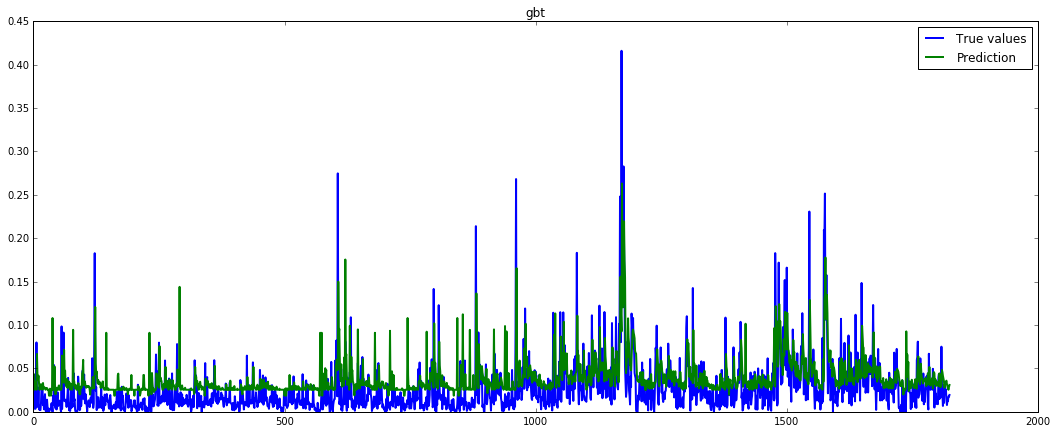

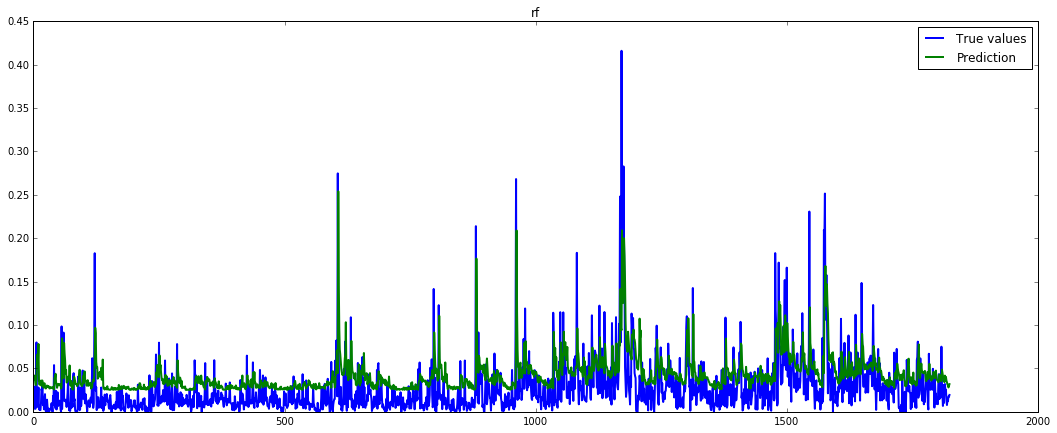

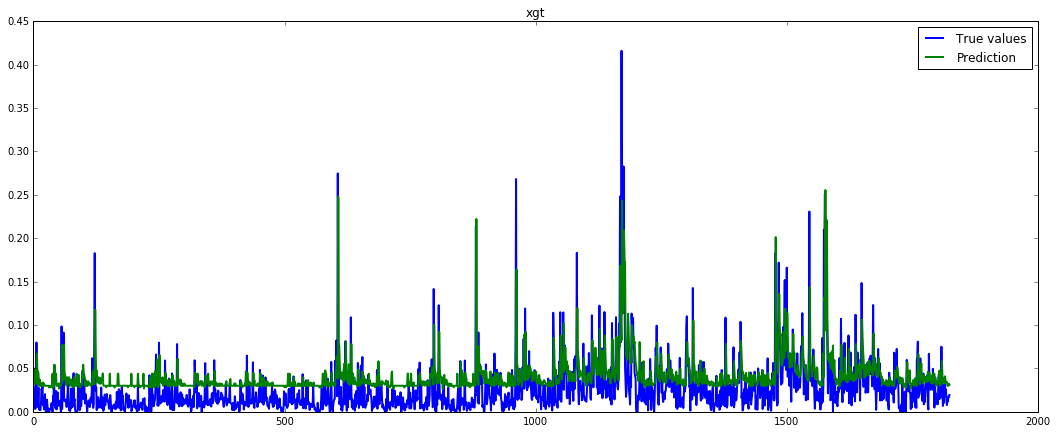

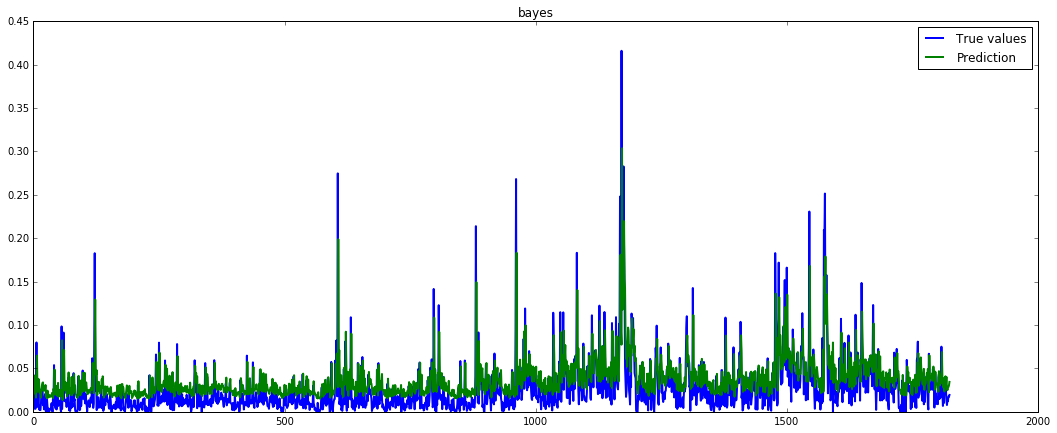

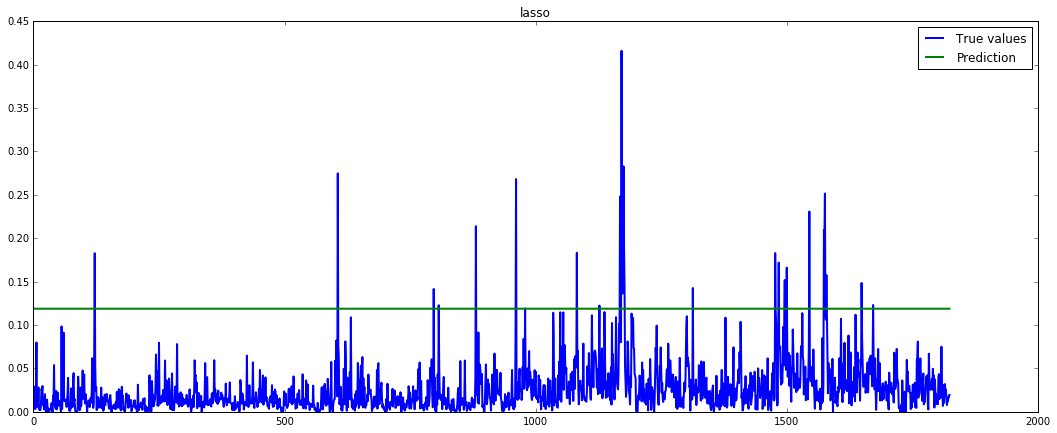

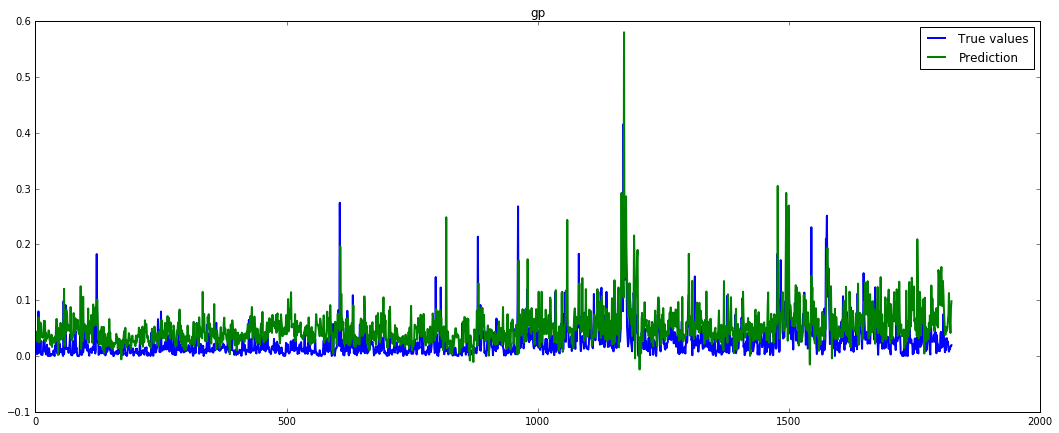

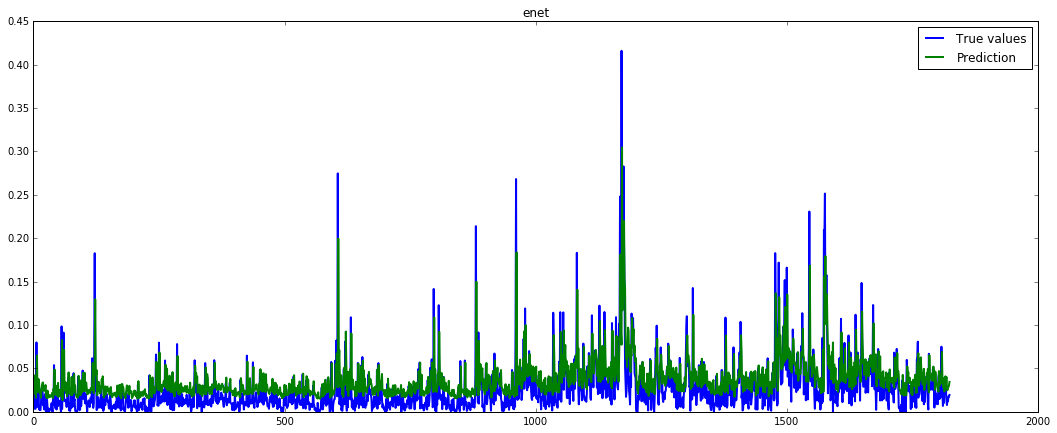

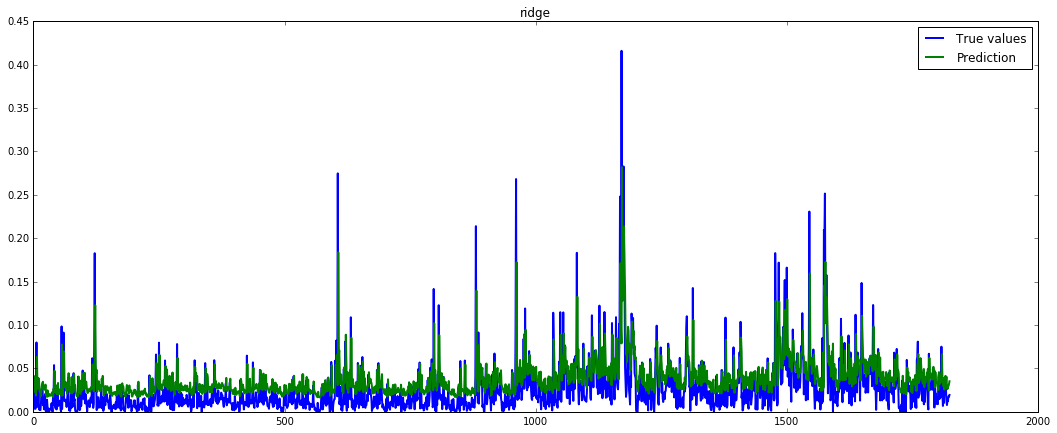

In [477]:
name_format = ['truth', 'pre', 'pre_v', 'pre_b']
models = ['gbt', 'rf', 'xgt', 'bayes', 'lasso', 'gp', 'enet', 'ridge']
#, 'arima'
#'arimax'
postfix = '.txt'

for i in models:
    plot_prediction_truth(file_path + 'pytest_' + i + postfix , i, 0, 3000, ['truth', 'pre'])
    


0.0296665250654


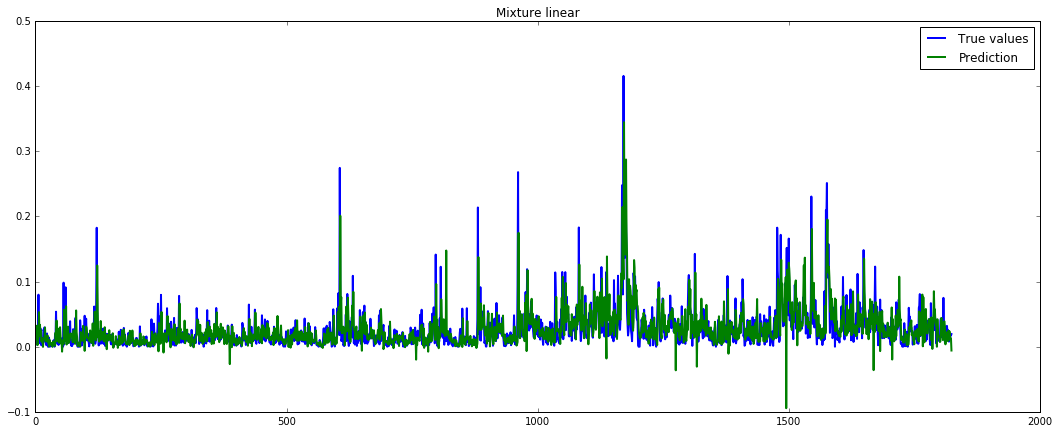

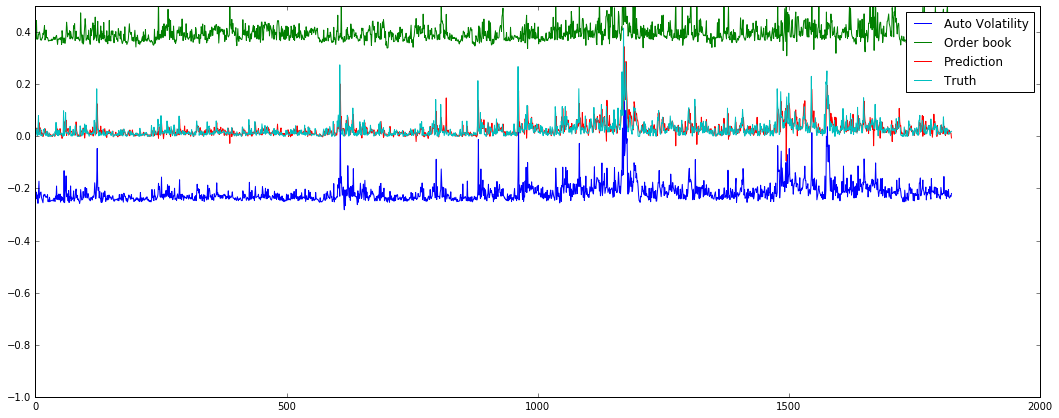

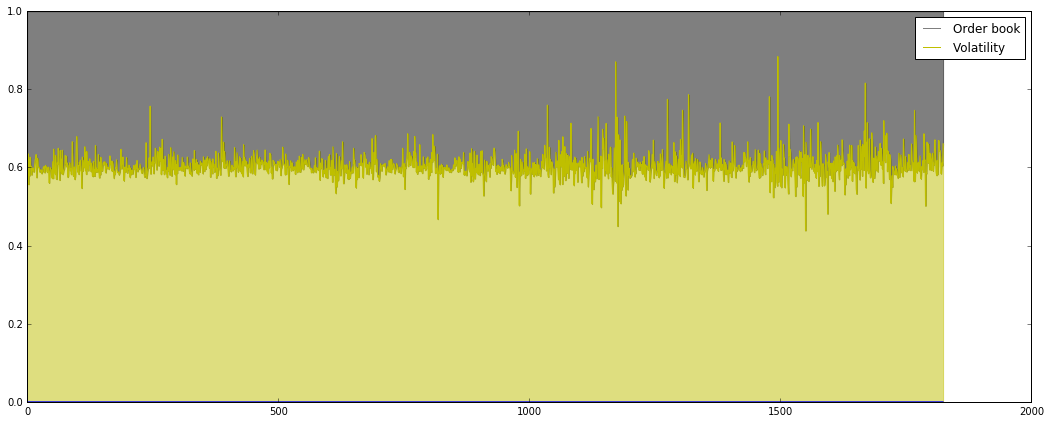

In [500]:
#---- TESTING ----

tmpdf = pd.read_csv('../bt_results/res/pytest_mix.txt', sep=',', names = ['truth', 'pre', 'pre_v', 'pre_b'])
tmp = tmpdf['pre'] - tmpdf['truth']
print sqrt(mean(tmp*tmp))

gate_tr = pd.read_csv('../bt_results/res/gate_train.txt',sep=',', names = ['vol','ob'])
gate_ts = pd.read_csv('../bt_results/res/gate_test.txt', sep=',', names = ['vol','ob'])

plot_l = 0
plot_r = 3000
plot_prediction_truth('../bt_results/res/pytest_mix.txt', 'Mixture linear', plot_l, plot_r, name_format)
tmp_gate =  np.asarray(gate_ts.iloc[plot_l:plot_r])

# for i in range(3, len(tmp_gate)-3):
#      tmp_gate[i][0] = mean([tmp_gate[j][0] for j in range(i+1, i+2)])

mix_pre_df = pd.read_csv(file_path + 'pytest_mix.txt', sep=',', names = name_format)

fig, ax = plt.subplots()
fig.set_size_inches( 18,7 )
    
ax.plot(mix_pre_df['pre_v'].iloc[plot_l:plot_r], label = 'Auto Volatility')
ax.plot(mix_pre_df['pre_b'].iloc[plot_l:plot_r], label = 'Order book')
ax.plot(mix_pre_df['pre'].iloc[plot_l:plot_r], label = 'Prediction')
ax.plot(mix_pre_df['truth'].iloc[plot_l:plot_r], label = 'Truth')

ax.set_ylim(-1, 0.5)
ax.legend()

X = range(len(tmp_gate))
Y =  [1.0 for i in tmp_gate ]
Y1 = [i[0] for i in tmp_gate]
Y2 = [0.0 for i in tmp_gate]

fig, ax = plt.subplots()
fig.set_size_inches( 18,7 )

ax.plot(Y, label = 'Order book', color='k', alpha=.5)
ax.plot(Y1,label = 'Volatility', color = 'y')
ax.plot(Y2,)
plt.fill_between(X, Y, Y1, color='k',alpha=.5)
plt.fill_between(X, Y1,Y2, color='y',alpha=.5)

ax.legend(loc=0)

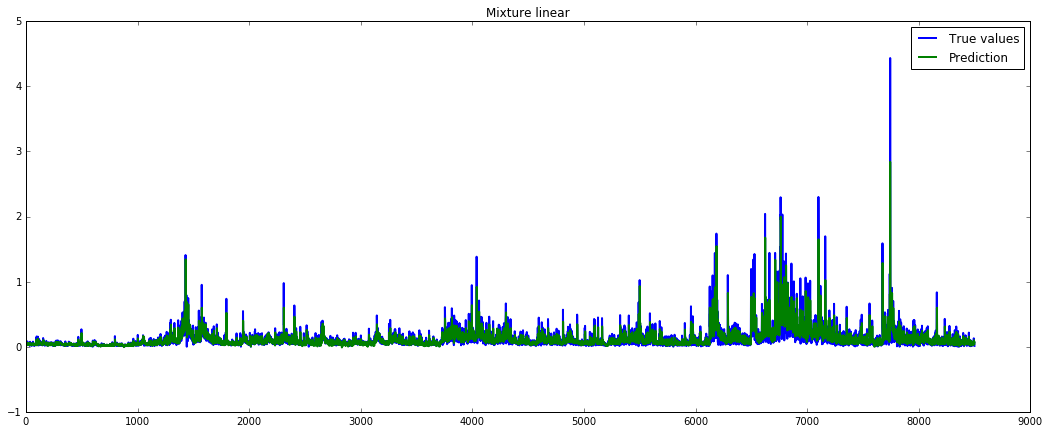

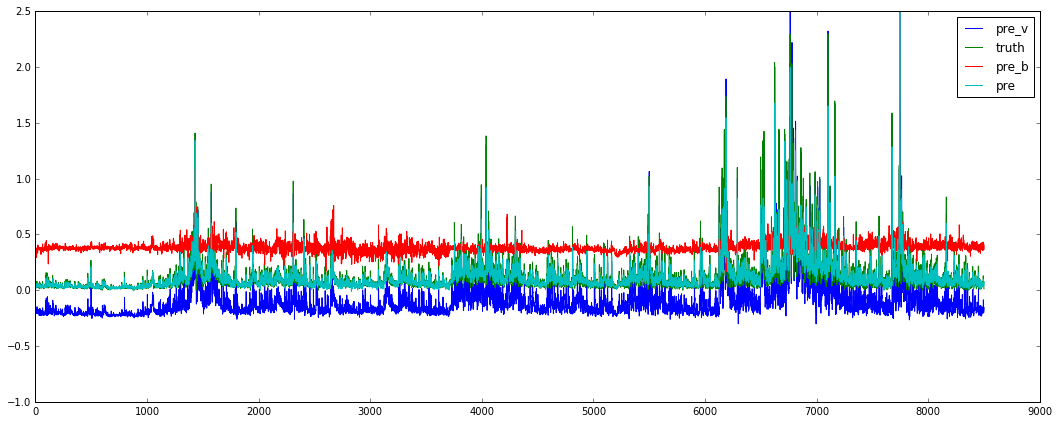

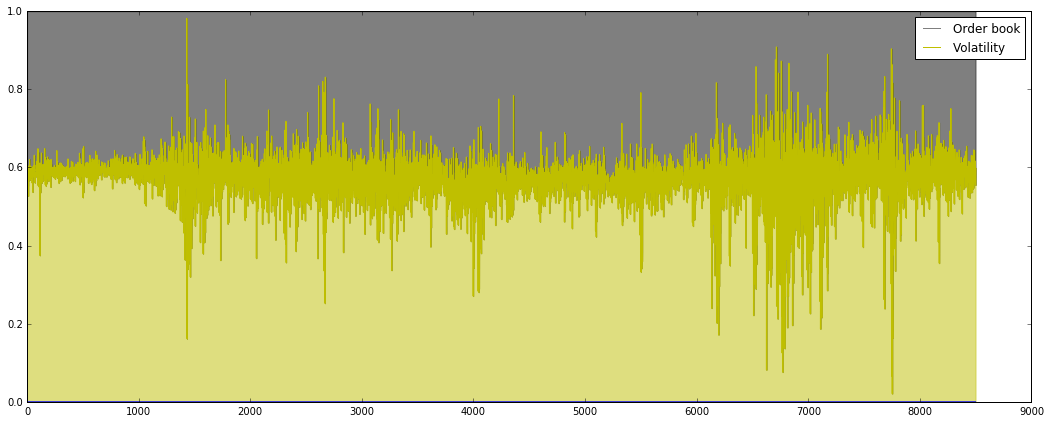

In [501]:
# TRAINING

gate_tr = pd.read_csv('../bt_results/res/gate_train.txt',sep=',', names = ['vol','ob'])
gate_ts = pd.read_csv('../bt_results/res/gate_test.txt', sep=',', names = ['vol','ob'])

plot_l = 0
plot_r = 10000
plot_prediction_truth('../bt_results/res/pytrain_mix.txt', 'Mixture linear', plot_l, plot_r, name_format)

tmp_gate =  np.asarray(gate_tr.iloc[plot_l:plot_r])

# for i in range(3, len(tmp_gate)-3):
#      tmp_gate[i][0] = mean([tmp_gate[j][0] for j in range(i+1, i+2)])

mix_pre_df = pd.read_csv(file_path + 'pytrain_mix.txt', sep=',', names = name_format)

fig, ax = plt.subplots()
fig.set_size_inches( 18,7 )

ax.plot(mix_pre_df['pre_v'].iloc[plot_l:plot_r], label = 'pre_v')
ax.plot(mix_pre_df['truth'].iloc[plot_l:plot_r], label = 'truth')
ax.plot(mix_pre_df['pre_b'].iloc[plot_l:plot_r], label = 'pre_b')
ax.plot(mix_pre_df['pre'].iloc[plot_l:plot_r], label = 'pre')
# ax.plot(mix_pre_df['truth'].iloc[plot_l:plot_r], label = 'Truth')

ax.set_ylim(-1, 2.5)
ax.legend()

X = range(len(tmp_gate))
Y =  [1.0 for i in tmp_gate ]
Y1 = [i[0] for i in tmp_gate]
Y2 = [0.0 for i in tmp_gate]

fig, ax = plt.subplots()
fig.set_size_inches( 18,7 )

ax.plot(Y, label = 'Order book', color='k', alpha=.5)
ax.plot(Y1,label = 'Volatility', color = 'y')
ax.plot(Y2,)
plt.fill_between(X, Y, Y1, color='k',alpha=.5)
plt.fill_between(X, Y1,Y2, color='y',alpha=.5)

ax.legend(loc=0)

In [503]:
# ---- error evaluation ----

def eval_mape(file_add, file_col_names):
    
    df = pd.read_csv(file_add, sep=',', names = file_col_names)
    
    diff = df['truth'] - df['pre']

    tmp = (abs(diff)/(df['truth']+1e-10))

    tmpsum = []
    for i in range(len(tmp)):
        if abs(df['truth'].iloc[i])>1e-3:
            tmpsum.append( tmp[i] )
                    
    return mean(tmpsum)

# ---- MAPE

name_format = ['truth', 'pre', 'pre_v', 'pre_b']
models = ['gbt', 'rf', 'xgt', 'bayes', 'lasso', 'gp', 'enet', 'ridge']
#, 'arima'
#'arimax'
#'str', 'strx',  'garch', 'egarch'

file_path = "../bt_results/res/"
prefix_ts = 'pytest_'
prefix_tr = 'pytrain_'
postfix = '.txt'

print 'mix', eval_mape( file_path + prefix_ts + 'mix' + postfix, ['truth', 'pre', 'pre_v', 'pre_b'])

for i in models:
    print i, eval_mape( file_path + prefix_ts + i + postfix, ['truth', 'pre'])

# ---- MSE
    
# print "\n-- residual of mixture comopared with baseline test:"
# residual_cmparison_sig_test(models, file_path, prefix_ts, name_format)

# print "\n-- residual normality test:"
# residual_test(models, file_path, prefix_ts, name_format)

mix 1.25848677347
gbt 2.27894751633
rf 2.54839704734
xgt 2.4679026984
bayes 1.97973634277
lasso 10.2159777322
gp 1.766967305
enet 1.97577096938
ridge 2.07111448011


In [ ]:
# visualize patterns of mixtures

gate_tr = np.asarray( pd.read_csv('../bt_results/res/gate_train.txt',sep=',', names = ['vol','ob']) )
gate_ts = np.asarray( pd.read_csv('../bt_results/res/gate_test.txt', sep=',', names = ['vol','ob']) )

tr_df = pd.read_csv(file_path + 'pytrain_mix.txt', sep=',', names = name_format)
ts_df = pd.read_csv(file_path + 'pytest_mix.txt', sep=',', names = name_format)

xtrain = np.load("../dataset/bitcoin/training_data/xtrain_"+file_postfix+".dat")
xtest  = np.load("../dataset/bitcoin/training_data/xtest_" +file_postfix+".dat")
ytrain = np.load("../dataset/bitcoin/training_data/ytrain_"+file_postfix+".dat")
ytest  = np.load("../dataset/bitcoin/training_data/ytest_" +file_postfix+".dat")

In [441]:
def errorfill(x, y, yerr, interval, color=None, alpha_fill=0.3, ax=None):
    ax = ax if ax is not None else plt.gca()
    if color is None:
        color = ax._get_lines.color_cycle.next()
    if np.isscalar(yerr) or len(yerr) == len(y):
        ymin = y - yerr
        ymax = y + yerr
    elif len(yerr) == 2:
        ymin, ymax = yerr
    ax.plot(x, y, color=color)
    ax.set_ylim(interval)
    ax.fill_between(x, ymax, ymin, color=color, alpha=alpha_fill)

[[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa0fc503410>


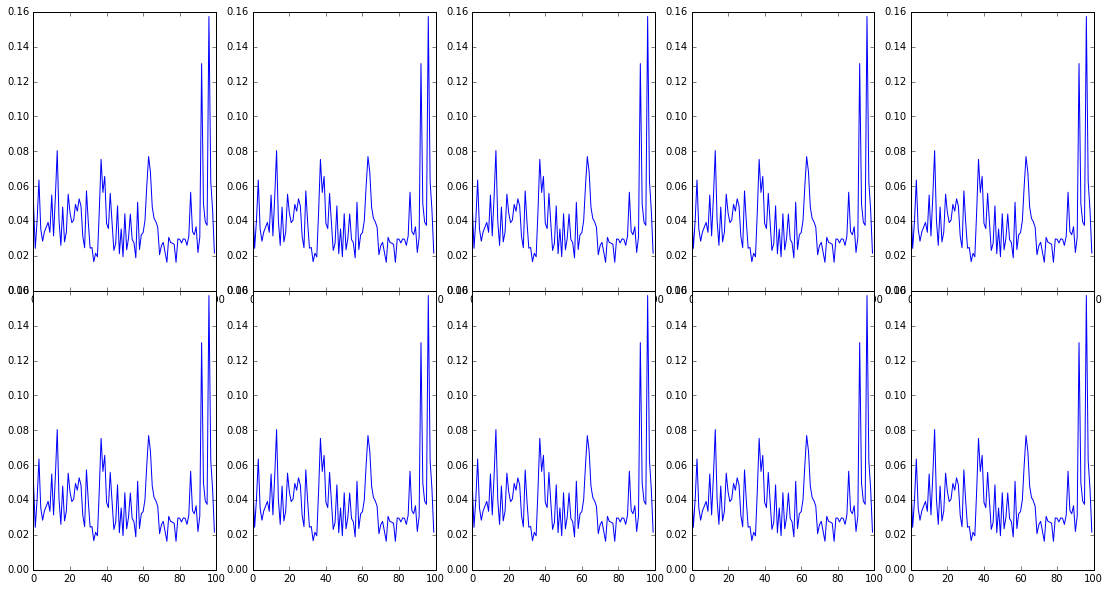

In [459]:
# pos = []
# for i in range(len(gate_tr)):
    
#     if gate_tr[i][0]>0.7 and gate_tr[i][0]<0.9:
#         pos.append(i)

# print len(pos)

# np.random.shuffle(pos)

# pos_sample = xtrain[ pos[:50] ]

# fig, ax = plt.subplots()
# fig.set_size_inches( 18,7 )

# for i in range(len(pos_sample)):
#     ax.plot(pos_sample[i][0], label = 'pre_v')
    
    
# ax.plot(mix_pre_df['truth'].iloc[plot_l:plot_r], label = 'truth')
# ax.plot(mix_pre_df['pre_b'].iloc[plot_l:plot_r], label = 'pre_b')


fig, ax_list = plt.subplots(2, 5, figsize=(19,10))
# fig.set_size_inches( 4,7 )

print ax_list

for i in range(2):
    for j in range(5):
        ax_list[i][j].plot(range(100), ytrain[:100], label = 'pre_v')

fig.subplots_adjust(hspace=0)
# for i in range(len(pos_sample)):
#     ax.plot(pos_sample[i][1][0], label = 'pre_v')
    
# fig, ax = plt.subplots()
# fig.set_size_inches( 18,7 )

# for i in range(len(pos_sample)):
#     ax.plot(pos_sample[i][1][1], label = 'pre_v')
    
    
# f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')
# ax1.plot(x, y)
# ax1.set_title('Sharing x per column, y per row')
# ax2.scatter(x, y)
# ax3.scatter(x, 2 * y ** 2 - 1, color='r')
# ax4.plot(x, 2 * y ** 2 - 1, color='r')

51


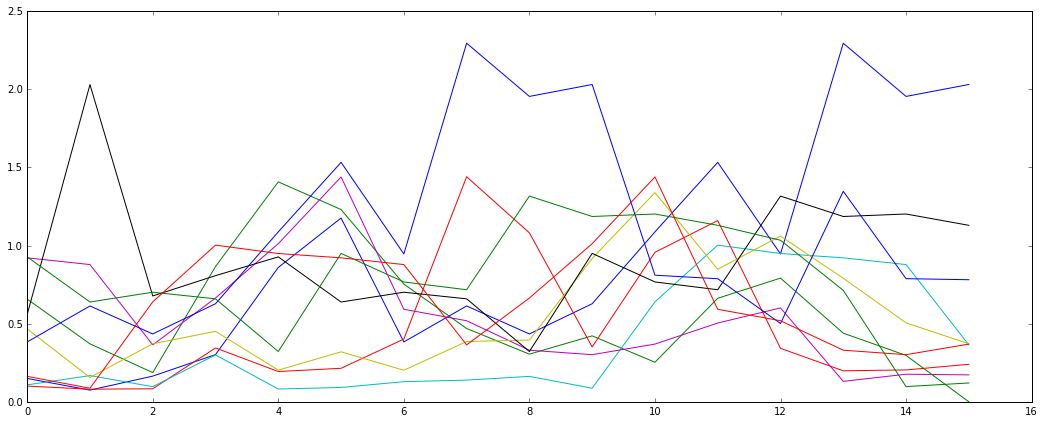

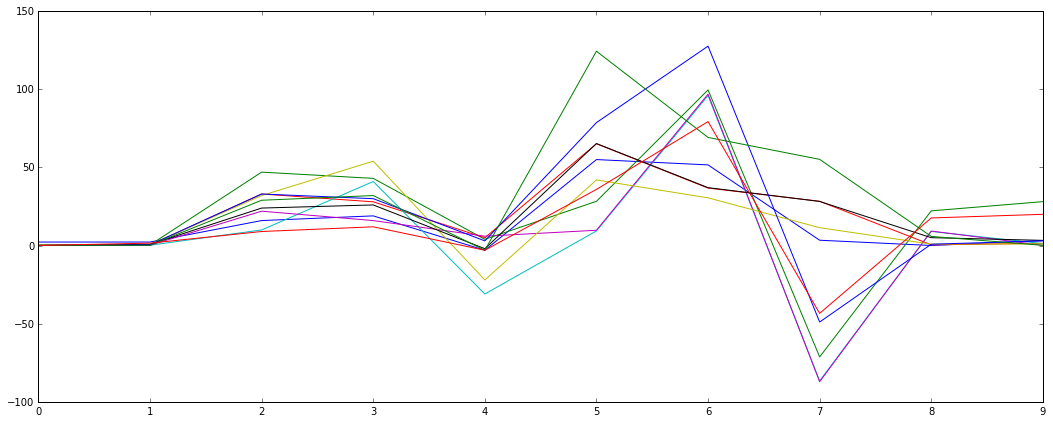

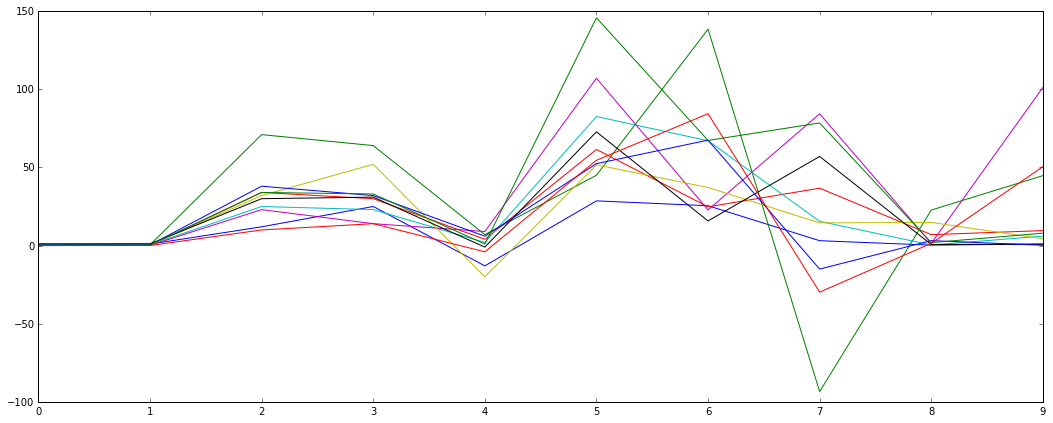

In [392]:
pos = []
neg = []
for i in range(len(gate_tr)):
    
    if gate_tr[i][0]<0.5 and gate_tr[i][0]>0.3:
        pos.append(i)
#     else:
#         neg.append(i)

print len(pos)

np.random.shuffle(pos)

pos_sample = xtrain[ pos[:10] ]


fig, ax = plt.subplots()
fig.set_size_inches( 18,7 )

for i in range(len(pos_sample)):
    ax.plot(pos_sample[i][0], label = 'pre_v')
    
    
fig, ax = plt.subplots()
fig.set_size_inches( 18,7 )

for i in range(len(pos_sample)):
    ax.plot(pos_sample[i][1][0], label = 'pre_v')
    
    
    
fig, ax = plt.subplots()
fig.set_size_inches( 18,7 )

for i in range(len(pos_sample)):
    ax.plot(pos_sample[i][1][1], label = 'pre_v')

In [283]:
def mixture_gate_condition_on_vol( pre, gate, y, lower, upper ):
   
    tmpv = []
    tmpob= []

    gatev = []
    gateob= []
    
    gate = np.asarray(gate)
    pre = np.asarray(pre)
    
    gateup = 0
    
    for i in range(1,len(gate)):
        tmp_v =  pre[i][2]
        tmp_ob = pre[i][3]
        
        g_v =  gate[i][0]
        g_ob = gate[i][1]
        
        if pre[i][0] >=lower and pre[i][0]<=upper and  pre[i][0] < pre[i-1][0] :
            tmpv.append(tmp_v)
            tmpob.append(tmp_ob)
            
            gatev.append(g_v)
            gateob.append(g_ob)
            
            if g_ob < gate[i-1][1]:
                gateup+=1
            
    
    print lower, upper, " : ", len(tmpv), mean(tmpv), mean(gatev), \
    mean(tmpob), mean(gateob), gateup/(len(gateob)+1e-10), gateup, len(gateob) 
#     ' p-value: ', sp.stats.ttest_ind(tmpv,tmpob)[1]

mix_pre_train = pd.read_csv(file_path + 'pytrain_mix.txt', sep=',', names = name_format)
mix_pre_test  = pd.read_csv(file_path + 'pytest_mix.txt',  sep=',', names = name_format)


print 'Training:'
for i in range(0,60):
    mixture_gate_condition_on_vol( mix_pre_train, gate_tr, ytrain, 0.01*i, 0.01*(i+1) )
    
    
print '\nTesting:'
for i in range(1,50):
    mixture_gate_condition_on_vol( mix_pre_test, gate_ts, ytest, 0.01*i, 0.01*(i+1) )

Training:
0.0 0.01  :  45 0.0541385329432 0.908192927308 -0.0883380864643 0.0918070665949 0.555555555554 25 45
0.01 0.02  :  288 0.0431761166288 0.936211018306 -0.171541982363 0.0637889801876 0.541666666666 156 288
0.02 0.03  :  500 0.0560065115988 0.926711458325 -0.112835773084 0.0732885434028 0.516 258 500
0.03 0.04  :  570 0.067134998595 0.914050471574 -0.0906714352175 0.0859495296777 0.501754385965 286 570
0.04 0.05  :  503 0.0805387560641 0.905677115882 -0.0722855504595 0.0943228833445 0.506958250497 255 503
0.05 0.06  :  366 0.101437634498 0.899042178617 -0.0514684366011 0.100957824812 0.551912568306 202 366
0.06 0.07  :  317 0.117937034072 0.875692636997 -0.0185845213875 0.124307362361 0.501577287066 159 317
0.07 0.08  :  272 0.131102655439 0.870749372222 -0.00581833588726 0.129250624997 0.485294117647 132 272
0.08 0.09  :  200 0.145748059116 0.859134736508 0.0185963538941 0.140865263102 0.51 102 200
0.09 0.1  :  175 0.163224634486 0.849291757856 0.0104665811147 0.150708245708 0

0.0 4.43378288192
0.278353388213 0.292948328338


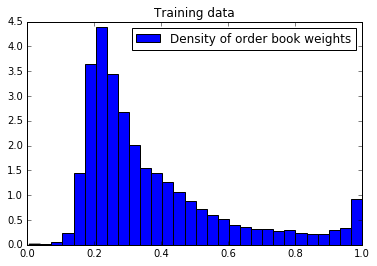

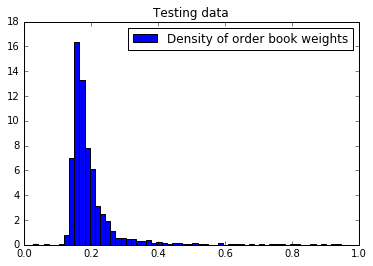

In [149]:
# conditional distribution of mixture weights on discrete volatility ranges 

print min(ytrain), max(ytrain)
print min(ytest), max(ytest)


fig, ax = plt.subplots()
ax.hist(gate_tr['ob'], histtype='bar', bins=30, normed= 1, label='Density of order book weights')
ax.legend()
# ax.set_ylim(0,10)
ax.set_xlim(0,1.0)
plt.title("Training data")
# ax.title("Training data")

fig, ax = plt.subplots()
ax.hist(gate_ts['ob'], histtype='bar', bins=60, normed= 1, label='Density of order book weights')
ax.legend()
# ax.set_ylim(0,10)
ax.set_xlim(0,1.0)
plt.title("Testing data")
# ax.title("Training data")


-- residual of mixture comopared with baseline test:
gbt : Ks_2sampResult(statistic=0.64329411764705879, pvalue=0.0)
rf : Ks_2sampResult(statistic=0.63388235294117645, pvalue=0.0)
xgt : Ks_2sampResult(statistic=0.68282352941176472, pvalue=0.0)
bayes : Ks_2sampResult(statistic=0.61317647058823521, pvalue=0.0)
lasso : Ks_2sampResult(statistic=0.89129411764705879, pvalue=0.0)
gp : Ks_2sampResult(statistic=0.51435294117647057, pvalue=1.9690349631162664e-246)
enet : Ks_2sampResult(statistic=0.61223529411764699, pvalue=0.0)
ridge : Ks_2sampResult(statistic=0.61599999999999999, pvalue=0.0)
str : Ks_2sampResult(statistic=0.79152941176470593, pvalue=0.077271766236952352)
strx : Ks_2sampResult(statistic=0.92752941176470594, pvalue=0.022949622348945969)
garch : Ks_2sampResult(statistic=0.81270588235294117, pvalue=0.0)
egarch : Ks_2sampResult(statistic=0.77882352941176469, pvalue=0.0)

-- residual normality test:
mix KstestResult(statistic=0.45822218803510578, pvalue=0.0)
[  4.90381949e-01   8.49

/home/guo/.local/lib/python2.7/site-packages/statsmodels/sandbox/stats/diagnostic.py:295: RuntimeWarning: divide by zero encountered in divide
  acf2norm = acfx[1:maxlag+1]**2 / (nobs - np.arange(1,maxlag+1))


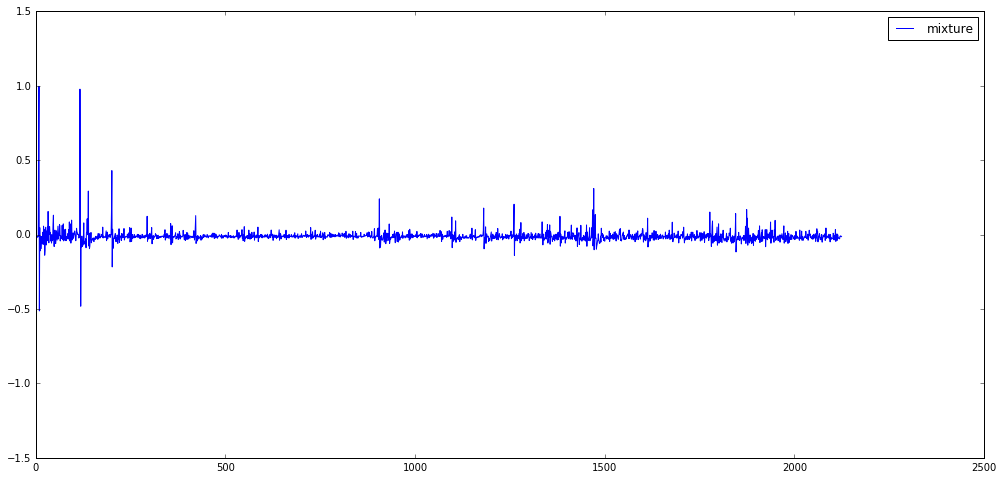

In [108]:
residual_plot(models, file_path, prefix_ts, name_format)
# plot_l = 0
# plot_r = 2000

# plot_prediction_truth('../bt_results/res/pytest_bayes.txt', 'Bayes regression', plot_l, plot_r)
# plot_prediction_truth('../bt_results/res/pytest_enet.txt', 'Elastic net', plot_l, plot_r)
# plot_prediction_truth('../bt_results/res/pytest_rf.txt', 'Random forest', plot_l, plot_r)
# plot_prediction_truth('../bt_results/res/pytest_gbt.txt', 'Gradient boostet tree', plot_l, plot_r)

# plot_prediction_truth('res/pytest.txt', 'Mixture linear', plot_l, plot_r)

In [ ]:
'''
# backup

#---- log sq ----

test_df = pd.read_csv('res/pytest.txt',    sep=',', names = ['pred', 'true'])
gate_tr = pd.read_csv('res/gate_train.txt',sep=',', names = ['vol','ob'])
gate_ts = pd.read_csv('res/gate_test.txt', sep=',', names = ['vol','ob'])
print test_df.shape, gate_tr.shape, gate_ts.shape

plot_horizon = 20
plot_prediction_truth('res/pytest.txt', 'Mixture linear', plot_horizon)
tmp_gate =  np.asarray(gate_ts.iloc[:plot_horizon])

# for i in range(3, len(tmp_gate)-3):
#      tmp_gate[i][0] = mean([tmp_gate[j][0] for j in range(i-1, i+1)])

X = range(len(tmp_gate))
Y =  [1.0 for i in tmp_gate ]
Y1 = [i[0] for i in tmp_gate]
Y2 = [0.0 for i in tmp_gate]

fig, ax = plt.subplots()
fig.set_size_inches( 18,7 )

ax.plot(Y, label = 'Order book', color='k', alpha=.5)
ax.plot(Y1,label = 'Volatility', color = 'y')
ax.plot(Y2,)
plt.fill_between(X, Y, Y1, color='k',alpha=.5)
plt.fill_between(X, Y1,Y2, color='y',alpha=.5)

ax.legend(loc=0)

#---- sq ----

test_df = pd.read_csv('../bt_results/res/pytest.txt',    sep=',', names = ['pred', 'true'])
gate_tr = pd.read_csv('../bt_results/res/gate_train.txt',sep=',', names = ['vol','ob'])
gate_ts = pd.read_csv('../bt_results/res/gate_test.txt', sep=',', names = ['vol','ob'])
print test_df.shape, gate_tr.shape, gate_ts.shape

plot_l = 0
plot_r = 250

plot_prediction_truth('../bt_results/res/pytest.txt', 'Mixture linear', plot_l, plot_r)
tmp_gate =  np.asarray(gate_ts.iloc[plot_l:plot_r])

#for i in range(3, len(tmp_gate)-3):
 #    tmp_gate[i][0] = mean([tmp_gate[j][0] for j in range(i-1, i+1)])

X = range(len(tmp_gate))
Y =  [1.0 for i in tmp_gate ]
Y1 = [i[0] for i in tmp_gate]
Y2 = [0.0 for i in tmp_gate]

fig, ax = plt.subplots()
fig.set_size_inches( 18,7 )

ax.plot(Y, label = 'Order book', color='k', alpha=.5)
ax.plot(Y1,label = 'Volatility', color = 'y')
ax.plot(Y2,)
plt.fill_between(X, Y, Y1, color='k',alpha=.5)
plt.fill_between(X, Y1,Y2, color='y',alpha=.5)

ax.legend(loc=0)